In [12]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import matplotlib.pyplot as plt

from skactiveml.pool import UncertaintySampling, GreedySamplingX, GreedySamplingTarget, QueryByCommittee

from skactiveml.regressor import SklearnRegressor

Sources for activeml:
https://scikit-activeml.github.io/latest/generated/tutorials/02_pool_regression_getting_started.html
https://www.preprints.org/frontend/manuscript/799d8399c7124b39f21cfd2cd49dccaf/download_pub

In [13]:
# Default parameters for matplotlib plots
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.facecolor'] = (0.9,0.9,0.9)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'w'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['legend.fontsize'] = 22
mpl.rcParams['legend.facecolor'] = [1,1,1]
mpl.rcParams['legend.framealpha'] = 0.75
mpl.rcParams['axes.labelsize'] = 22

In [14]:
# helper function for plotting the results
def plot():
    # data for plotting
    X_plot = np.linspace(0, 20, 1000)[:, None]
    y_GP, y_std = regressor.predict(X_plot, return_std=True)
    y_GP = y_GP.reshape(-1)

    plt.scatter(X, y_true, c="k", label="data")
    plt.plot(X_plot, y_GP, color="navy", lw=1, label="GPR")
    plt.fill_between(X_plot[:, 0], y_GP - y_std, y_GP + y_std, color="blue", alpha=0.2)
    plt.title("Initial estimation based on %i points"%n_initial)
    plt.legend(loc="best", scatterpoints=1, prop={"size": 12})

In [15]:
# Adapted from: https://www.preprints.org/manuscript/202507.0252/v1

# generate noisy sin(x) data
random_state = np.random.RandomState(0)
X = random_state.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y_true =  (np.sin(X) + np.random.normal(scale=0.3, size=X.shape)).ravel()


In [16]:
kernel = RBF(length_scale = 1.0, length_scale_bounds=(1e-4, 1e4)) \
         + WhiteKernel(noise_level = 1, noise_level_bounds = (1e-10, 1e+1))

gp = GaussianProcessRegressor(random_state=0, kernel = kernel)

regressor = SklearnRegressor(gp, random_state=0, missing_label=np.nan)

qs =  GreedySamplingTarget(method="GSi", random_state=0)

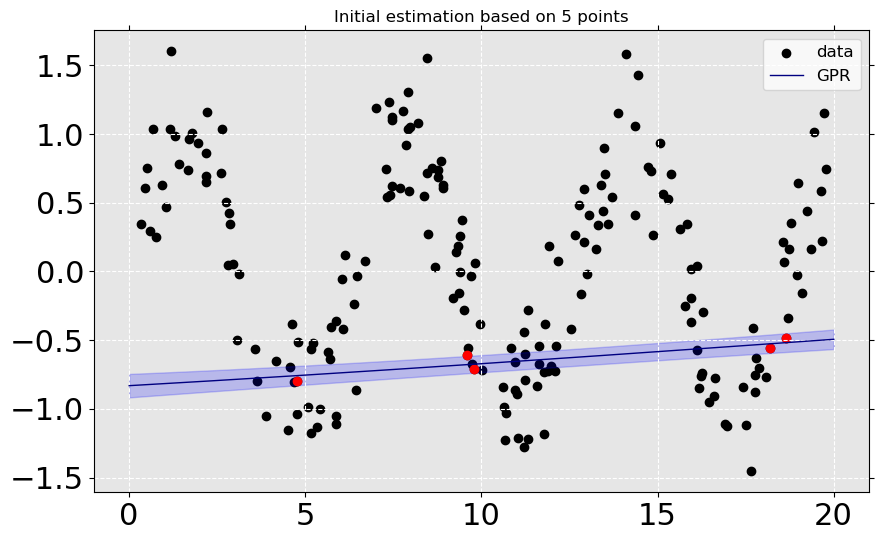

In [17]:
n_initial = 5
initial_idx = np.random.choice(range(len(X)), size = n_initial, replace = False)
y_training = np.full_like(y_true, fill_value=np.nan)
y_training[initial_idx] = y_true[initial_idx]

# only samples are considered where y_training is not NaN, in that case only 5
regressor.fit(X, y_training)

plot()
l=plt.scatter(X, y_training, c="red")

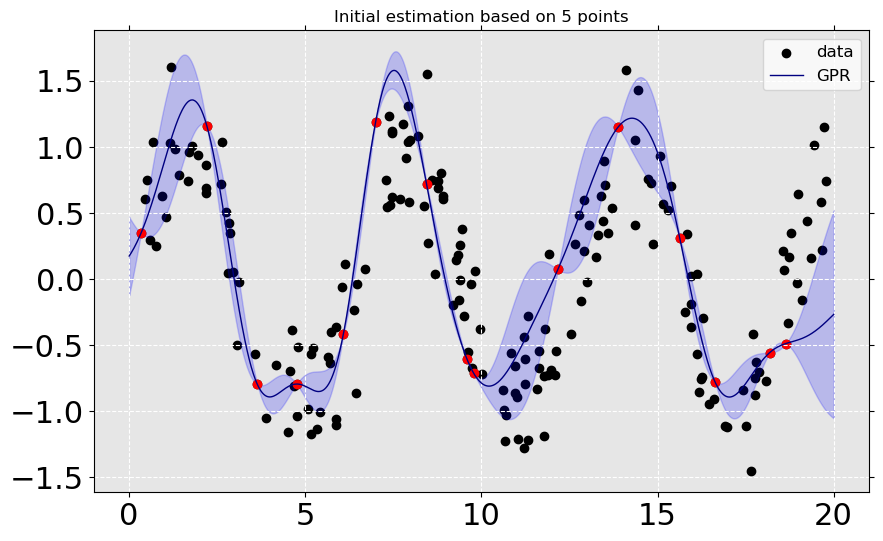

In [18]:
# active learning
n_cycles = 10
for c in range(n_cycles):
    regressor.fit(X, y_training)
    q_ids, u_scores = qs.query(X=X, y=y_training, reg=regressor, fit_reg=False, batch_size=1, return_utilities=True)
    # update y_training
    y_training[q_ids] = y_true[q_ids]
    
# Fit final regressor.
regressor.fit(X, y_training)


plot()
l=plt.scatter(X, y_training, c="red")

In [19]:
# --->>> Your turn <<<---
# Try to apply active learning to the penguins dataset
#
# See https://scikit-activeml.github.io/latest/generated/tutorials/00_pool_getting_started.html

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from skactiveml.pool import UncertaintySampling
from skactiveml.classifier import SklearnClassifier
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

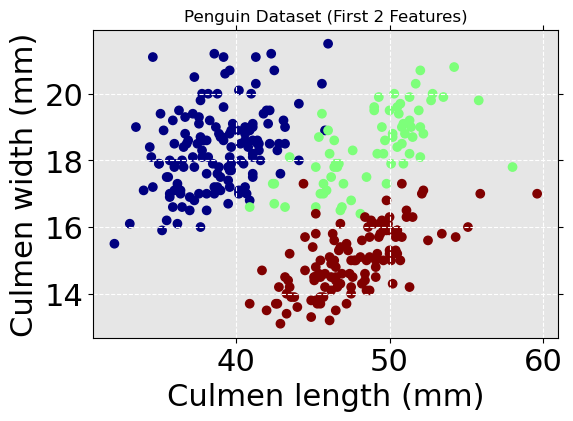

In [20]:
# load the data set
penguin = pd.read_csv('penguins_size.csv')
# Drop rows with any NaN values
penguin = penguin.dropna()

# Encode species to get a numeric target
le = LabelEncoder()
penguin["species_encoded"] = le.fit_transform(penguin["species"])
target_names = le.classes_

#X = penguin[['culmen_length_mm', 'culmen_depth_mm']].values  # Use only first 2 features
X = penguin[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']].values
y_true = penguin['species_encoded'].values  # 3 classes

# Define plot bounds
bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]

# scatter plot of first two features of the dataset
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='jet')
plt.xlabel('Culmen length (mm)')
plt.ylabel('Culmen width (mm)')
plt.title('Penguin Dataset (First 2 Features)')
plt.show()

In [21]:
# prepare model
logReg = LogisticRegression()

clf = SklearnClassifier(logReg, classes=np.unique(y_true))

qs = UncertaintySampling(method='entropy', random_state=42)

In [22]:
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

n_initial = 4
initial_idx = np.random.choice(range(len(X)), size = n_initial, replace = False)
y[initial_idx] = y_true[initial_idx]
clf.fit(X, y)


SklearnClassifier(classes=array([0, 1, 2]), estimator=LogisticRegression())

In [23]:
# Initialize tracking lists
accuracy = []
n_samples = []

# active learning
n_cycles = 140
for c in range(n_cycles):
    query_idx = qs.query(X=X, y=y, clf=clf, batch_size=1)
    y[query_idx] = y_true[query_idx]
    clf.fit(X, y)

     # Track number of labeled samples and accuracy
    accuracy.append(clf.score(X, y_true))
    n_samples.append(len(labeled_indices(y)))


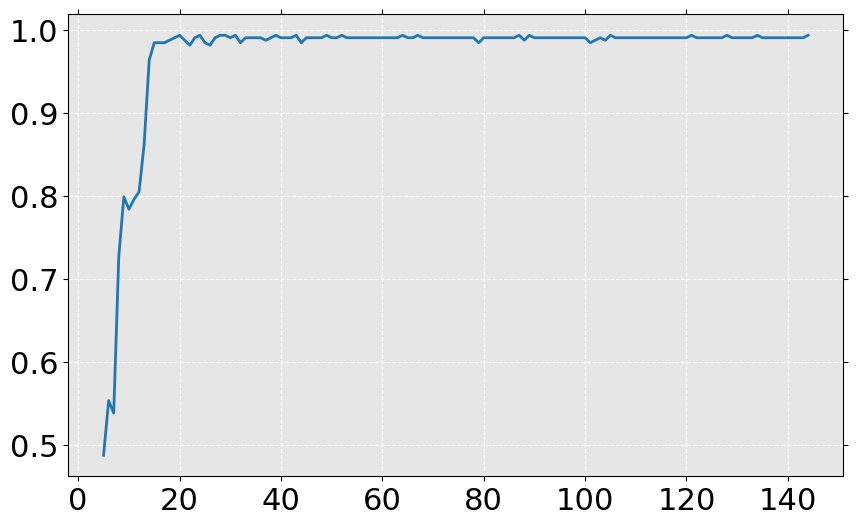

In [24]:
# plot accuracy versus n_samples
plt.plot(n_samples, accuracy)

In [25]:
# --->>> Your turn <<<---
# Try to apply active learning to the iris flower dataset
#
# See https://scikit-activeml.github.io/latest/generated/tutorials/00_pool_getting_started.html

from sklearn.datasets import load_iris

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from skactiveml.pool import UncertaintySampling
from skactiveml.classifier import SklearnClassifier
from skactiveml.utils import unlabeled_indices, labeled_indices, MISSING_LABEL

import warnings
warnings.filterwarnings("ignore")

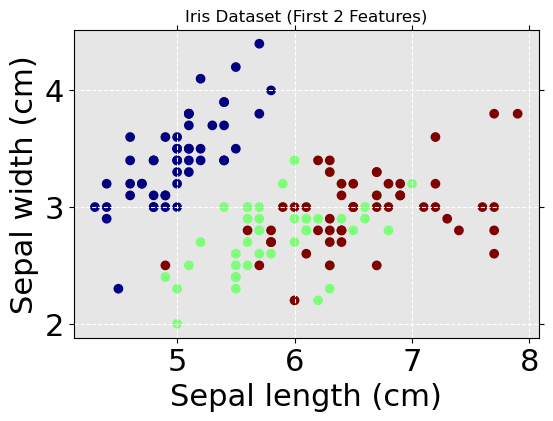

In [ ]:
# Load Iris dataset
iris = load_iris()
X = iris.data  
y_true = iris.target  # 3 classes

# Define plot bounds
bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='jet')
plt.xlabel('Sepal length (cm)')
plt.ylabel('Sepal width (cm)')
plt.title('Iris Dataset (First 2 Features)')
plt.show()

In [27]:
# prepare model
logReg = LogisticRegression()

clf = SklearnClassifier(logReg, classes=np.unique(y_true))

qs = UncertaintySampling(method='entropy', random_state=42)

In [28]:
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

n_initial = 4
initial_idx = np.random.choice(range(len(X)), size = n_initial, replace = False)
y[initial_idx] = y_true[initial_idx]
clf.fit(X, y)


SklearnClassifier(classes=array([0, 1, 2]), estimator=LogisticRegression())

In [29]:
# Initialize tracking lists
accuracy = []
n_samples = []

# active learning
n_cycles = 140
for c in range(n_cycles):
    query_idx = qs.query(X=X, y=y, clf=clf, batch_size=1)
    y[query_idx] = y_true[query_idx]
    clf.fit(X, y)

     # Track number of labeled samples and accuracy
    accuracy.append(clf.score(X, y_true))
    n_samples.append(len(labeled_indices(y)))


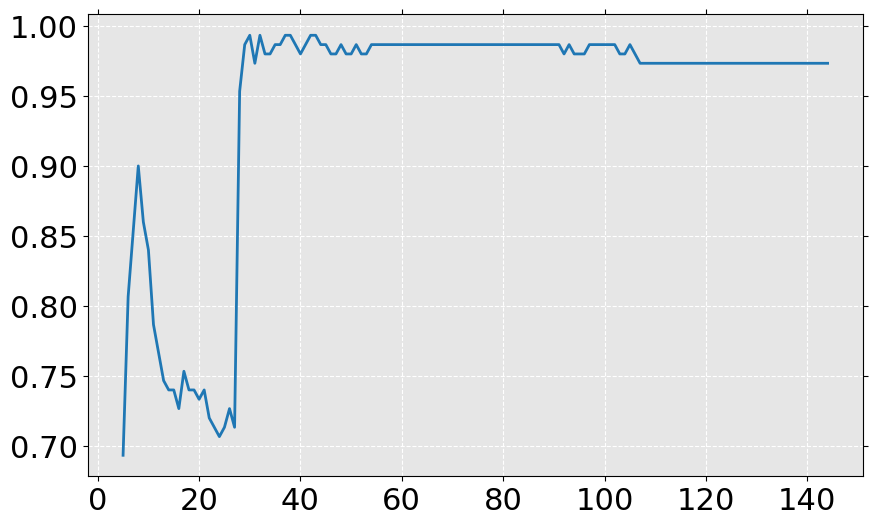

In [30]:
# plot accuracy versus n_samples
plt.plot(n_samples, accuracy)